In [438]:
try:    
    import alpaca_trade_api
except:
    !pip install PyYAML==5.4.1 --ignore-installed
    !pip install alpaca_trade_api
try:
    import stldecompose
except:
    !pip install scipy==1.2.1
    !pip install statsmodels==0.10.2
    !pip install stldecompose==0.0.5
!pip install xgboost

In [439]:
import importlib
from stldecompose import decompose
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from xgboost import XGBRegressor
from xgboost import plot_importance
import pandas as pd
from StlSlope import StlSlope
import ApiClient as ac
importlib.reload(ac)
#importlib.reload(StlSlope)

<module 'ApiClient' from 'e:\\Education\\UW\\EE P 596 A\\Assignment_05\\ApiClient.py'>

In [440]:
["FB", "MSFT","AMZN","AAPL","NFLX","AMD","GOOG"]
ticker = "GOOG"
Api_Key =''
Secret_Key=''
client = ac.ApiClient(api_key_Id=Api_Key,api_key_secret=Secret_Key)
df= client.get_closing_price(ticker,255)
df.index=pd.to_datetime(df.index,utc=True)

reading from file
e:\Education\UW\EE P 596 A\Assignment_05\data\GOOG.csv


In [441]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

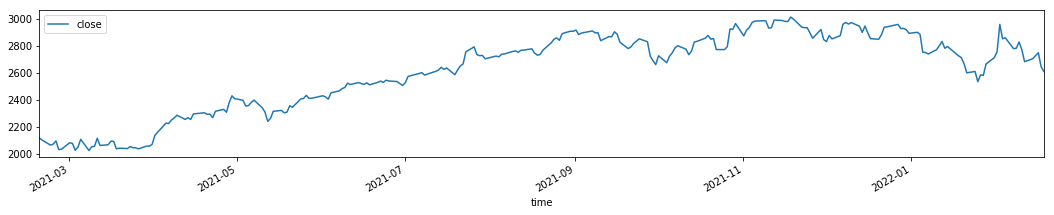

In [442]:
df[['close']].plot(figsize=(18, 3))

In [443]:
#train_,test_ = train_test_split(df,train_size = 7/12,  shuffle=False)
split=int(df.shape[0]*7/12)
train_ = df.iloc[:split]
test_ = df.iloc[split-1:]

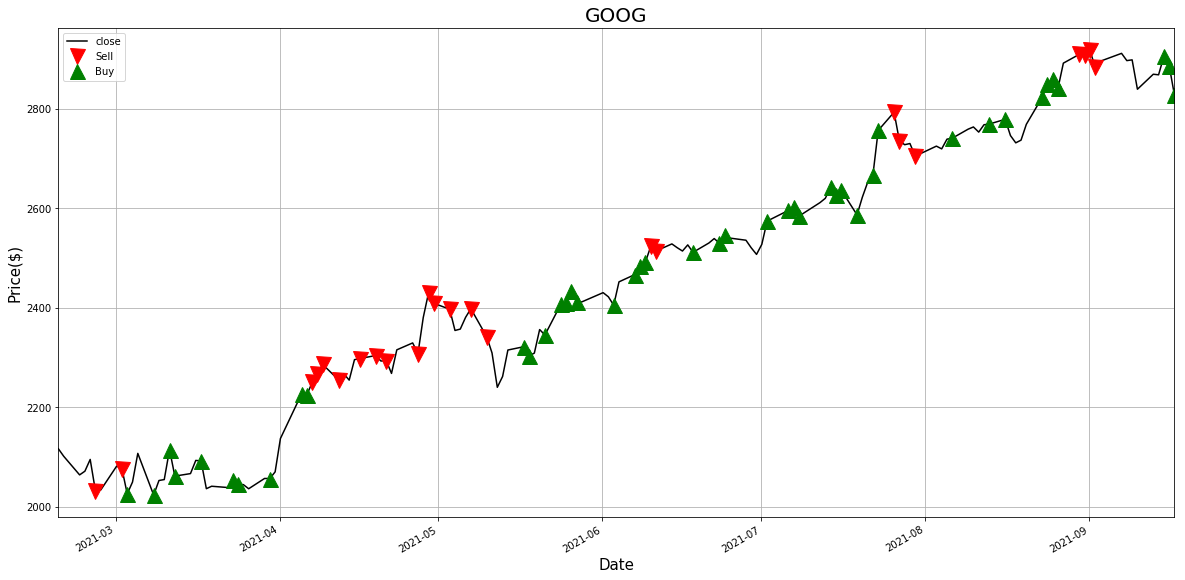

In [444]:
stl_close = StlSlope(ticker,train_,column='close',cycle=10,period=3)
stl_close.slope_strategy()
stl_close._plot()

In [445]:
stl_close = StlSlope(ticker,train_,column='close',cycle=10,period=3)
stl_close.slope_strategy()
train_y = stl_close.position
stl_open = StlSlope(ticker,train_,column='open',cycle=10,period=3)
stl_high = StlSlope(ticker,train_,column='high',cycle=10,period=3)
stl_low = StlSlope(ticker,train_,column='low',cycle=10,period=3)

In [446]:
train_x = pd.DataFrame(index=train_.index) 
train_x['close_resid'] = stl_close.decomp.resid.values
train_x['close_seasonal'] = stl_close.decomp.seasonal.values
train_x['close_trend'] = stl_close.decomp.trend.values
train_x['close'] = train_['close']
train_x['open_resid'] = stl_open.decomp.resid.values
train_x['high_seasonal'] = stl_high.decomp.resid.values
train_x['low_trend'] = stl_low.decomp.resid.values

In [447]:
train_x.head(2)

,close_resid,close_seasonal,close_trend,close,open_resid,high_seasonal,low_trend
time,,,,,,,
2021-02-18 05:00:00+00:00,9.040177,12.322525,1999.675743,2116.24,98.261303,80.182601,119.191880
2021-02-19 05:00:00+00:00,6.988728,15.904515,2005.918405,2101.29,99.929200,68.676527,103.962032


In [448]:
scaler = MinMaxScaler(feature_range=(-1, 1))
#train_x = scaler.fit_transform(train_x)
train_x[train_x.columns] = scaler.fit_transform(train_x[train_x.columns])

In [449]:
# trading only based on last day
train_x.iloc[:-1].shape,train_y[1:].shape

((147, 7), (147,))

In [450]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(train_x.iloc[:-1], train_y[1:])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [451]:
stl_close = StlSlope(ticker,test_,column='close',cycle=10,period=3)
stl_close.slope_strategy()
test_y = stl_close.position
stl_open = StlSlope(ticker,test_,column='open',cycle=10,period=3)
stl_high = StlSlope(ticker,test_,column='high',cycle=10,period=3)
stl_low = StlSlope(ticker,test_,column='low',cycle=10,period=3)
test_x = pd.DataFrame(index=test_.index) 
test_x['close_resid'] = stl_close.decomp.resid.values
test_x['close_seasonal'] = stl_close.decomp.seasonal.values
test_x['close_trend'] = stl_close.decomp.trend.values
test_x['close'] = test_['close']
test_x['open_resid'] = stl_open.decomp.resid.values
test_x['high_seasonal'] = stl_high.decomp.resid.values
test_x['low_trend'] = stl_low.decomp.resid.values
test_x[test_x.columns] = scaler.fit_transform(test_x[test_x.columns])

In [452]:
hold = 0
predict=[]
for i in clf.predict(test_x.iloc[:-1]):
  #sell
  if i ==-1 and hold ==1:
    predict.append(-1)
    hold = 0
  elif i ==1 and hold ==0:
    predict.append(1)
    hold = 1
  else:
    predict.append(0)
predict=np.array(predict)

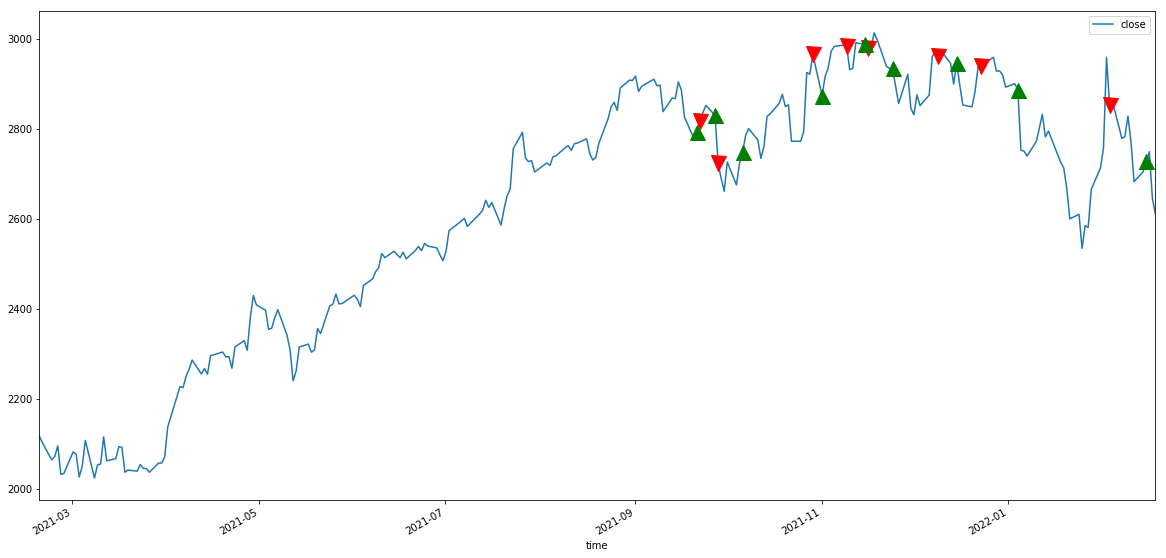

In [453]:
df[['close']].plot(figsize=(20, 10))
#plot sell
plt.plot(test_.iloc[1:].loc[predict == -1.0].index, 
                 test_.iloc[1:].close[predict == -1.0],'v', 
                 markersize=15, color='r', label="Sell")

#plot buy
plt.plot(test_.iloc[1:].loc[predict == 1.0].index, 
            test_.iloc[1:].close[predict == 1.0],'^', 
            markersize=15, color='g', label="Buy") 

In [454]:
h=100000
print('Principal: $',h)
sell = test_.iloc[1:].close[predict == -1.0]
buy = test_.iloc[1:].close[predict == 1.0]

for i in range(sell.shape[0]):
  h=h/buy[i]*sell[i]
print("Profit: $",int(h-100000),"\nThat's ",h/100000,"%")

Principal: $ 100000
Profit: $ 8063 
That's  1.0806303608812513 %
